## Testing HD plot

**Get Sv like normal**

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
azfp_xml_path = 'D:\\Documents\\Projects\\echopype\\echopype\\data\\azfp\\17041823.XML'
azfp_01a_path = 'D:\\Documents\\Projects\\echopype\\echopype\\data\\azfp\\17082117.01A'

In [3]:
from echopype.convert import Convert
tmp_convert = Convert(azfp_01a_path, azfp_xml_path)
tmp_convert.raw2nc()

File: 17082117.01A - Loading Profile #11925 21-Aug-2017 17:05:37 with xml=12022310.XML Bins2Avg=1 Time2Avg=40 Salinity=29.60 Pressure=60.0



In [4]:
from echopype.model import Model
tmp_echo = Model(tmp_convert.nc_path)
tmp_echo.calibrate()

13:34:36 saving calibrated Sv to D:\Documents\Projects\echopype\echopype\data\azfp\17082117_Sv.nc


**Plot like normal**

In [5]:
import matplotlib.pyplot as plt
tmp_echo.Sv.name = "Sv"
tmp_echo.Sv.isel(frequency=0).plot(x='ping_time', y='range_bin', cmap='jet', robust=True)
plt.show()

<Figure size 640x480 with 2 Axes>

**Add range**

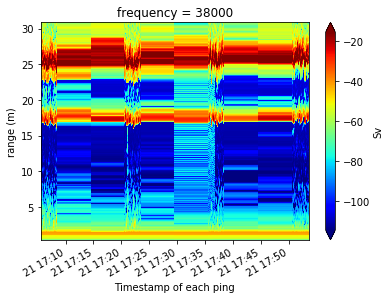

In [6]:
depth = tmp_echo.calc_range().isel(frequency=0)
da = tmp_echo.Sv.isel(frequency=0).assign_coords(range=depth)
da = da.swap_dims({'range_bin': 'range'})
da.plot(x='ping_time', y='range', cmap='jet', robust=True)
plt.ylabel("range (m)")
plt.show()

**Make ping bin**

In [7]:
import numpy as np
import xarray as xr
ping_bin = xr.DataArray(np.arange(tmp_echo.Sv.ping_time.size), coords=[("ping_time", tmp_echo.Sv.ping_time)])

**Swap ping bin and ping time**

In [8]:
new_da = da.assign_coords(ping_bin=ping_bin)
new_da = new_da.swap_dims({'ping_time': 'ping_bin'})

**Reinsert ping time**

In [9]:
index = lambda m, n: [i*n//m + n//(2*m) for i in range(m)]
ping_index = index(10, new_da.ping_time.size)
pings=[str(new_da.ping_time.values[i].astype('datetime64[m]')).split('T')[1] for i in ping_index]

In [10]:
new_da.plot(x='ping_bin', y='range', cmap='jet', robust=True)
locs, labels = plt.xticks()
plt.xticks(ping_index, pings)
plt.xlabel("ping number")
plt.ylabel("range (m)")
plt.xticks(rotation=45)
plt.show()

**Or use hvplot**

In [11]:
import hvplot.xarray
tmp_echo.Sv.hvplot(y='range_bin', x='ping_time', cmap='jet',width=500, height=400)

:DynamicMap   [frequency]
   :Image   [ping_time,range_bin]   (Sv)

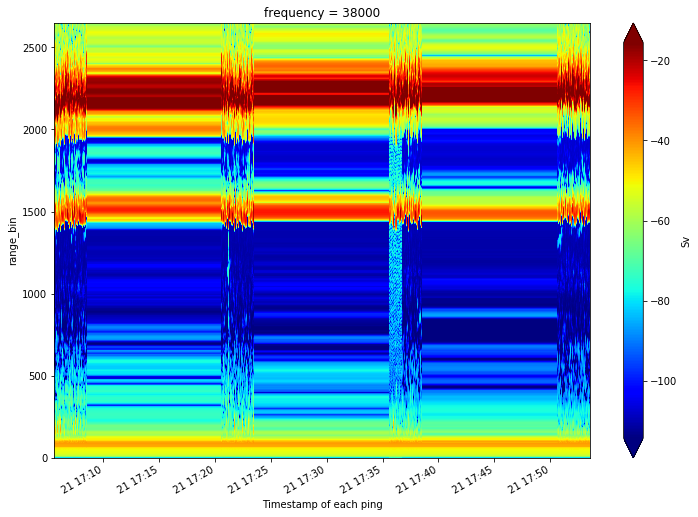

In [12]:
tmp_echo.Sv.isel(frequency=0).plot(x='ping_time', y='range_bin', cmap='jet', robust=True, size=8, infer_intervals=False)

In [13]:
import pandas as pd

In [28]:
ts=tmp_echo.Sv.ping_time.to_series()
ts.values

array(['2017-08-21T17:05:37.000000000', '2017-08-21T17:05:40.000000000',
       '2017-08-21T17:05:43.000000000', '2017-08-21T17:05:46.000000000',
       '2017-08-21T17:05:49.000000000', '2017-08-21T17:05:52.000000000',
       '2017-08-21T17:05:55.000000000', '2017-08-21T17:05:58.000000000',
       '2017-08-21T17:06:01.000000000', '2017-08-21T17:06:04.000000000',
       '2017-08-21T17:06:07.000000000', '2017-08-21T17:06:10.000000000',
       '2017-08-21T17:06:13.000000000', '2017-08-21T17:06:16.000000000',
       '2017-08-21T17:06:19.000000000', '2017-08-21T17:06:22.000000000',
       '2017-08-21T17:06:25.000000000', '2017-08-21T17:06:28.000000000',
       '2017-08-21T17:06:31.000000000', '2017-08-21T17:06:34.000000000',
       '2017-08-21T17:06:37.000000000', '2017-08-21T17:06:40.000000000',
       '2017-08-21T17:06:43.000000000', '2017-08-21T17:06:46.000000000',
       '2017-08-21T17:06:49.000000000', '2017-08-21T17:06:52.000000000',
       '2017-08-21T17:06:55.000000000', '2017-08-21

In [15]:
new_time=xr.DataArray.from_series(ts.reindex(ts.resample('3s').asfreq().index, method='nearest').interpolate('time'))

In [23]:
import matplotlib
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.)

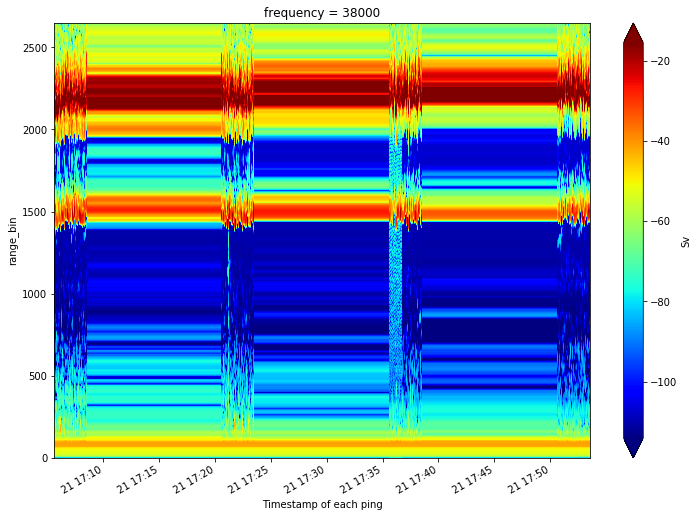

In [25]:
test_sv = tmp_echo.Sv
newest_ds = test_sv.reindex(indexers={'ping_time': new_time}).isel(frequency=0)
newest_ds.plot(x='ping_time', y='range_bin', cmap=cmap, infer_intervals=False, size=8, robust=True)

In [30]:
with xr.open_dataset(tmp_convert.nc_path, group='Vendor') as ds_vend:
    ping_per_profile = ds_vend.ping_per_profile
    ping_period = ds_vend.ping_period
    burst_int = ds_vend.burst_interval

OSError: [Errno group not found: Vendor] 'Vendor'